In [10]:
import numpy as np
import matplotlib.pyplot as plt

def mutual_information(x, y, bins=16, eps=1e-12):
    """
    Estimate Mutual Information between x and y via 2D histograms.
    
    Args:
        x, y: 1D numpy arrays of the same length.
        bins: number of bins to use for discretization.
        eps: small value to avoid log(0).

    Returns:
        Estimated mutual information in bits (if log base=2).
    """
    # 1. Compute 2D histogram of x and y
    counts_xy, x_edges, y_edges = np.histogram2d(x, y, bins=bins)
    
    # 2. Convert counts to joint probabilities
    p_xy = counts_xy / np.sum(counts_xy)
    
    # 3. Compute marginals p(x), p(y)
    p_x = np.sum(p_xy, axis=1, keepdims=True)  # sum over y dimension
    p_y = np.sum(p_xy, axis=0, keepdims=True)  # sum over x dimension

    # 4. Sum up p_xy * log( p_xy / (p_x * p_y) )
    # We’ll use log base 2 => MI in bits.
    # Make sure to handle zero counts properly.
    valid = p_xy > 0
    mi = np.sum(p_xy[valid] * np.log2( p_xy[valid] / (p_x[valid[:,0]] * p_y[0,valid[0]]) ))
    
    return mi


In [11]:
def transfer_entropy(x, y, bins=16, lag=1, eps=1e-12):
    """
    Estimate Transfer Entropy T_{X->Y} for a 1D time series x, y using 
    naive discrete histograms (lag-1).

    Args:
        x, y: 1D numpy arrays, same length T.
        bins: number of bins for discretization.
        lag: the time shift to measure X at time t vs. Y at time t+1.
        eps: small offset to avoid log(0).

    Returns:
        Estimated transfer entropy from x to y in bits.
        
    Note:
        T_{X->Y}(lag=1) uses data points:
          - y_{t+1}, y_t, x_t
          for t = 0..(T-2) if lag=1
          (We skip the last index or so to avoid out-of-range indexing).
    """
    length = len(x)
    if len(y) != length:
        raise ValueError("x and y must have the same length.")
    if length <= lag:
        raise ValueError("Time series is too short for the given lag.")

    # We'll form arrays:
    #   X_t   = x[0 : T-lag-1]
    #   Y_t   = y[0 : T-lag-1]
    #   Y_t+1 = y[1 : T-lag]
    # Actually for lag=1: 
    #   y_{t+1} is y[t+1], 
    #   y_t is y[t], 
    #   x_t is x[t].
    # We'll skip the final point(s) to align all.

    x_t = x[:-lag-1]
    y_t = y[:-lag-1]
    y_next = y[1:-lag]

    # 1. 3D histogram for (x_t, y_t, y_{t+1})
    # Flatten them into shape (N,) each
    # We'll collect them into columns for np.histogramdd
    data_3d = np.vstack([x_t, y_t, y_next]).T  # shape (N, 3)
    counts_3d, edges = np.histogramdd(data_3d, bins=(bins, bins, bins))
    p_xyz = counts_3d / np.sum(counts_3d)   # joint distribution p(x,y,y_next)

    # 2. We also need:
    #    p(y,y_next), p(y,x,y_next), etc.
    #    We'll handle them by summation over the relevant axes.
    #    p_xy_ = sum over y_next axis
    #    p_yy_ = sum over x axis, etc.

    # a) p(y_t, x_t) = sum over y_next dimension
    p_xy = np.sum(p_xyz, axis=2)  # shape (bins, bins)
    # b) p(y_t, y_next) = sum over x dimension
    p_yy = np.sum(p_xyz, axis=0)  # shape (bins, bins)
    # c) p(y_t) = sum over x and y_next
    p_y  = np.sum(p_yy, axis=1)   # shape (bins,)

    # Transfer Entropy sum:
    # T_{X->Y} = sum_{all} p(x_t, y_t, y_{t+1}) * log2( p(y_{t+1}| y_t, x_t) / p(y_{t+1}| y_t) )
    # where p(y_{t+1}| y_t, x_t) = p(x_t, y_t, y_{t+1}) / p(x_t, y_t)
    #       p(y_{t+1}| y_t)     = p(y_t, y_{t+1}) / p(y_t)

    te = 0.0
    # We'll iterate over the 3D bin indices (i_x, i_y, i_ynext)
    # to accumulate p(x,y,y_next)*log(...) only for bins with p>0.
    for i_x in range(bins):
        for i_y in range(bins):
            for i_yn in range(bins):
                p_val = p_xyz[i_x, i_y, i_yn]
                if p_val <= 0:
                    continue
                
                # p(x_t, y_t) is p_xy[i_x, i_y]
                p_xy_val = p_xy[i_x, i_y]
                if p_xy_val <= 0:
                    continue
                
                # p(y_t, y_{t+1}) is p_yy[i_y, i_yn]
                p_yy_val = p_yy[i_y, i_yn]
                # p(y_t) is p_y[i_y]
                
                # p(y_{t+1} | y_t, x_t) = p(x_t, y_t, y_{t+1}) / p(x_t, y_t)
                p_cond1 = p_val / p_xy_val

                # p(y_{t+1} | y_t) = p(y_t, y_{t+1}) / p(y_t)
                if p_y[i_y] <= 0:
                    continue
                p_cond2 = p_yy_val / p_y[i_y]

                # Transfer Entropy increment
                te += p_val * np.log2((p_cond1 + eps) / (p_cond2 + eps))

    return te


In [12]:
if __name__ == "__main__":
    # 1. Generate synthetic data
    np.random.seed(0)
    N = 2000
    A = np.random.randn(N)  # random signal
    # B depends partly on A shifted by 1
    B = 0.8 * np.roll(A, 1) + 0.2 * np.random.randn(N)
    # Just a mild shift-based coupling: B_t ~ 0.8*A_{t-1} + noise
    
    # 2. Compute mutual information
    mi_AB = mutual_information(A, B, bins=16)
    mi_BA = mutual_information(B, A, bins=16)
    
    print(f"Mutual Information MI(A;B) = {mi_AB:.4f} bits")
    print(f"Mutual Information MI(B;A) = {mi_BA:.4f} bits (should be same)\n")
    
    # 3. Compute transfer entropy
    te_AtoB = transfer_entropy(A, B, bins=16, lag=1)
    te_BtoA = transfer_entropy(B, A, bins=16, lag=1)
    
    print(f"Transfer Entropy T(A->B) = {te_AtoB:.4f} bits")
    print(f"Transfer Entropy T(B->A) = {te_BtoA:.4f} bits\n")
    
    # 4. Interpretation
    # - MI is symmetric, so MI(A;B) == MI(B;A).
    # - TE can be asymmetric; T(A->B) > T(B->A) suggests A "drives" B more than vice versa.

    # 5. (Optional) Quick example plotting for different bins
    bins_list = [4, 8, 16, 32, 64]
    te_results_AtoB = []
    te_results_BtoA = []
    
    for b in bins_list:
        te_results_AtoB.append(transfer_entropy(A, B, bins=b, lag=1))
        te_results_BtoA.append(transfer_entropy(B, A, bins=b, lag=1))
    
    plt.plot(bins_list, te_results_AtoB, marker='o', label='T(A->B)')
    plt.plot(bins_list, te_results_BtoA, marker='o', label='T(B->A)')
    plt.xlabel('Number of Bins')
    plt.ylabel('Transfer Entropy (bits)')
    plt.title('TE vs. Binning for Synthetic A->B Coupling')
    plt.legend()
    plt.show()


ValueError: operands could not be broadcast together with shapes (185,) (6,6) 

(2000,)
(2000,)


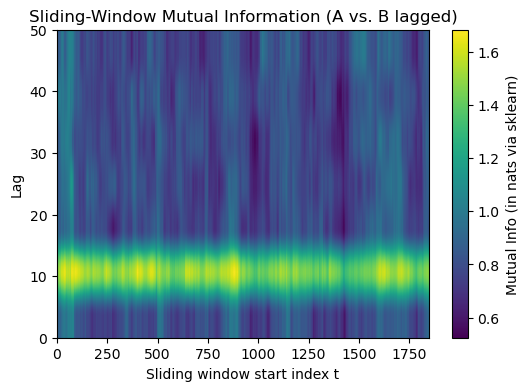

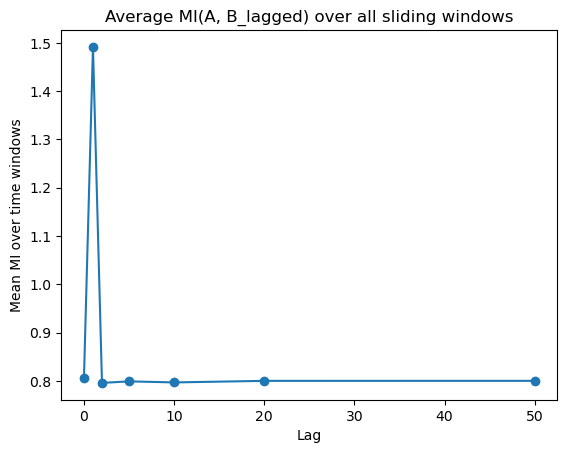

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mutual_info_score
def discretize(data, nbins=16):
    """
    Discretize continuous 1D data into 'nbins' bins, returning
    an array of integer bin indices (0 to nbins-1).
    """
    # Find bin edges over the range of data
    data_min, data_max = np.min(data), np.max(data)
    # If data is constant, just return zeros
    if data_min == data_max:
        return np.zeros_like(data, dtype=int)
    
    bin_edges = np.linspace(data_min, data_max, nbins + 1)
    # Digitize data into bins (each data point -> bin index)
    # np.digitize returns bin indices in [1..nbins], so subtract 1 to get [0..nbins-1]
    bin_indices = np.digitize(data, bin_edges) - 1
    
    # Ensure we stay within 0..nbins-1
    bin_indices = np.clip(bin_indices, 0, nbins-1)
    return bin_indices

def mutual_info_sklearn(x, y, nbins=16):
    """
    Compute mutual information between x and y by:
      1) Discretizing x and y into nbins.
      2) Using sklearn.metrics.mutual_info_score on the discrete labels.

    Returns:
      MI(x,y) in 'natural units' of mutual_info_score. 
      By default, mutual_info_score returns the MI in 'nats' if using np.log,
      but effectively it's just an unnormalized number. 
      (Sklearn's docs mention it's based on the NMI formula, but let's 
       treat it as a comparative measure.)
    """
    x_disc = discretize(x, nbins)
    y_disc = discretize(y, nbins)
    mi_value = mutual_info_score(x_disc, y_disc)
    return mi_value

def measure_mi_sliding_window_lag(x, y, window_size=100, lags=None, nbins=16):
    """
    Computes mutual information between X and a time-lagged Y in a sliding-window approach.

    Args:
        x, y : 1D numpy arrays of the same length.
        window_size : number of samples per sliding window.
        lags : list of integer lags (>= 0) to consider.
        nbins : number of bins for discretization in the MI calculation.

    Returns:
        - mi_matrix: 2D numpy array of shape (num_t, len(lags)), 
                     where num_t is the number of valid window positions in x.
                     mi_matrix[t_idx, lag_idx] = MI(x_window, y_window_lagged).
        - valid_t: a list of the starting time indices for which we compute MI.
    """
    if lags is None:
        lags = [0, 1, 2, 5, 10, 20]

    length = len(x)
    assert len(y) == length, "x and y must have the same length."

    # The largest lag might reduce the maximum t we can use
    max_lag = max(lags)
    # We'll allow windows up to length - window_size - max_lag
    num_t = length - window_size - max_lag
    if num_t <= 0:
        raise ValueError("Time series too short for the given window_size and max_lag.")
    
    mi_matrix = np.zeros((num_t, len(lags)), dtype=float)
    valid_t = list(range(num_t))  # 0..(num_t-1) in terms of start index
    
    for i, t in enumerate(valid_t):
        # X window: x[t : t+window_size]
        x_win = x[t : t + window_size]
        
        for j, lag in enumerate(lags):
            # Y window (lagged by 'lag'): y[t+lag : t+lag + window_size]
            y_start = t + lag
            y_win = y[y_start : y_start + window_size]
            
            mi_val = mutual_info_sklearn(x_win, y_win, nbins=nbins)
            mi_matrix[i, j] = mi_val
    
    return mi_matrix, valid_t

if __name__ == "__main__":
    # 1. Generate synthetic data
    np.random.seed(0)
    N = 2000
    A = np.random.randn(N)  # random signal
    # B depends partly on A shifted by 1
    B = 0.8 * np.roll(A, 1) + 0.2 * np.random.randn(N)
    # There's a mild shift-based coupling: B_t ~ 0.8*A_{t-1} + noise
    print(B.shape)
    print(A.shape)
    # 2. Define parameters for the sliding window approach
    window_size = 100
    lags = [0, 1, 2, 5, 10, 20, 50]  # pick lags of interest
    nbins = 16
    
    # 3. Compute sliding-window MI
    mi_matrix, valid_t = measure_mi_sliding_window_lag(
        A, B, window_size=window_size, lags=lags, nbins=nbins
    )
    
    # mi_matrix has shape (num_t, len(lags))
    # valid_t is the list of start indices in A for which we computed MI
    
    # 4. Plot the MI matrix as a heatmap:
    plt.figure(figsize=(6, 4))
    # y-axis is t index, x-axis is lag index
    # we might want to invert or transpose for a more intuitive view
    plt.imshow(mi_matrix.T, aspect='auto', origin='lower',
               extent=[valid_t[0], valid_t[-1], lags[0], lags[-1]])
    plt.colorbar(label='Mutual Info (in nats via sklearn)')
    plt.xlabel('Sliding window start index t')
    plt.ylabel('Lag')
    plt.title('Sliding-Window Mutual Information (A vs. B lagged)')
    plt.show()
    
    # 5. Example: Plot MI vs. lag averaged across time
    mi_mean_over_t = np.mean(mi_matrix, axis=0)
    
    plt.figure()
    plt.plot(lags, mi_mean_over_t, marker='o')
    plt.xlabel('Lag')
    plt.ylabel('Mean MI over time windows')
    plt.title('Average MI(A, B_lagged) over all sliding windows')
    plt.show()
